TRAIN_DIR: C:\Users\pc\Desktop\i2\deeplearning\projet\FaceMaskDataset\FaceMaskDataset\train224
TEST_DIR : C:\Users\pc\Desktop\i2\deeplearning\projet\FaceMaskDataset\FaceMaskDataset\test224
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']


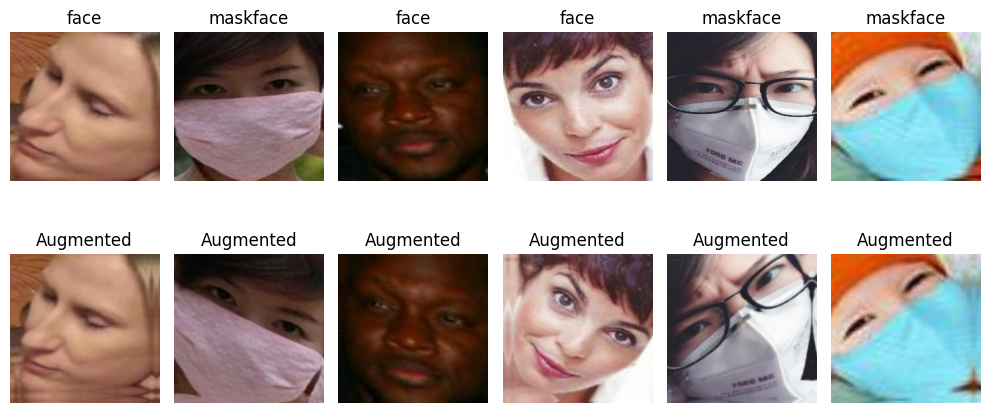

In [1]:
from load import load_data

train_ds, val_ds, test_ds, class_names, data_augmentation, IMG_SIZE, BATCH_SIZE = load_data(show_examples=True)

# Cellule – Modèle 2 (VGG16 gelé – Transfer Learning)

Dans cette cellule, on construit le **Modèle 2** basé sur l’architecture **VGG16 pré-entraînée sur ImageNet**.

- **Backbone pré-entraîné**
  - `VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))`
  - On enlève la tête de classification d’origine (`include_top=False`) pour réutiliser uniquement les **couches convolutionnelles** comme extracteur de caractéristiques.
  - `base_model.trainable = False` : toutes les couches du backbone sont gelées au début → on ne met à jour que les couches ajoutées au-dessus (stratégie de **transfer learning** classique).

- **Pipeline d’entrée**
  - `data_augmentation` : rotations, flips, etc. pour enrichir artificiellement le dataset.
  - `Rescaling(1./255)` : normalisation des pixels dans [0, 1].

- **Tête de classification ajoutée**
  - `GlobalAveragePooling2D()` : compresse les cartes de features en un vecteur global par canal, en réduisant le nombre de paramètres.
  - `Dense(256, relu)` : couche fully-connected pour apprendre une représentation adaptée à la tâche *face vs maskface*.
  - `Dropout(0.5)` : régularisation pour limiter l’overfitting.
  - `Dense(1, sigmoid)` : sortie binaire (probabilité d’être `maskface`).

Ce modèle exploite donc des **features visuelles générales** apprises sur ImageNet, puis ajoute une petite tête spécialisée pour la détection de masque, ce qui permet d’obtenir de bonnes performances même avec un dataset limité.

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False  # gelé au début

model_vgg = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])



In [22]:
model_vgg.build(input_shape=(None,) + IMG_SIZE + (3,)) 
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)              

## Compilation + callbacks (VGG16)

Même stratégie :
- Adam (lr=1e-3)
- binary_crossentropy
- metrics : accuracy, precision, recall
- EarlyStopping
- ReduceLROnPlateau
- Sauvegarde du meilleur modèle


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
)

checkpoint = ModelCheckpoint(
    "models/vgg16_best.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop_vgg = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_vgg = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

## Entraînement du modèle VGG16
On entraîne sur train_ds, avec validation sur val_ds.

In [24]:
history_vgg = model_vgg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint, early_stop_vgg, reduce_lr_vgg],
    verbose=1
)


Epoch 1/15
149/149 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.7557 - precision: 0.7626 - recall: 0.7361
Epoch 1: val_loss improved from inf to 0.39372, saving model to models\vgg16_best.h5
149/149 [==============================] - 85s 508ms/step - loss: 0.5003 - accuracy: 0.7557 - precision: 0.7626 - recall: 0.7361 - val_loss: 0.3937 - val_accuracy: 0.8325 - val_precision: 0.7913 - val_recall: 0.9187 - lr: 0.0010
Epoch 2/15
149/149 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8474 - precision: 0.8550 - recall: 0.8333
Epoch 2: val_loss improved from 0.39372 to 0.32342, saving model to models\vgg16_best.h5
149/149 [==============================] - 66s 446ms/step - loss: 0.3597 - accuracy: 0.8474 - precision: 0.8550 - recall: 0.8333 - val_loss: 0.3234 - val_accuracy: 0.8704 - val_precision: 0.8519 - val_recall: 0.9073 - lr: 0.0010
Epoch 3/15
149/149 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8717 - prec

## Courbes Loss + Accuracy (VGG16)

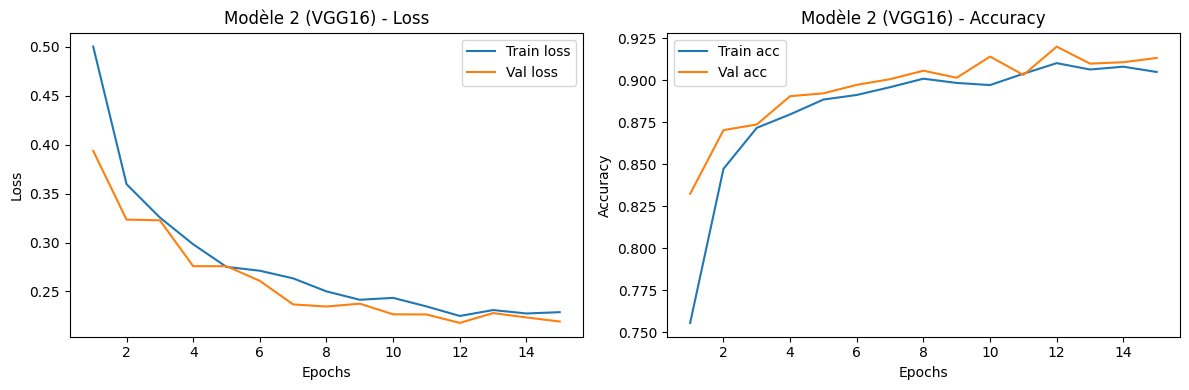

In [25]:
plot_history(history_vgg, title_prefix="Modèle 2 (VGG16)")

## Évaluation sur test_ds (VGG16)

In [26]:
test_results_vgg = model_vgg.evaluate(test_ds, verbose=1)
print("\nRésultats VGG16 :")
for name, value in zip(model_vgg.metrics_names, test_results_vgg):
    print(f"{name}: {value:.4f}")

96/96 [==============================] - 16s 165ms/step - loss: 0.2540 - accuracy: 0.9033 - precision: 0.8197 - recall: 0.9174

Résultats VGG16 :
loss: 0.2540
accuracy: 0.9033
precision: 0.8197
recall: 0.9174


##  Matrice de confusion + Classification Report (VGG16)

In [27]:
y_true = []
for _, labels in test_ds:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true, axis=0)

y_pred_proba = model_vgg.predict(test_ds)
y_pred = (y_pred_proba.ravel() > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


96/96 [==============================] - 13s 132ms/step
Confusion Matrix:
 [[1809  210]
 [  86  955]]

Classification Report:
              precision    recall  f1-score   support

        face       0.95      0.90      0.92      2019
    maskface       0.82      0.92      0.87      1041

    accuracy                           0.90      3060
   macro avg       0.89      0.91      0.90      3060
weighted avg       0.91      0.90      0.90      3060



# Interprétation des résultats – Modèle 2 (VGG16 gelé)

- **Performances sur le test**
  - `loss = 0.2540`
  - `accuracy ≈ 90,33 %`
  - `precision ≈ 0.82`
  - `recall ≈ 0.92`

Le modèle atteint une **bonne exactitude globale**, avec un **rappel élevé** : il détecte bien la plupart des visages masqués, mais il produit plus de faux positifs, ce qui fait baisser la précision.

- **Par classe (classification report)**  
  - Classe **`face`** :
    - precision = **0.95**
    - recall = **0.90**
    - → Les visages sans masque sont bien identifiés, mais certains sont confondus avec la classe `maskface`.
  - Classe **`maskface`** :
    - precision = **0.82**
    - recall = **0.92**
    - → Le modèle capture bien la majorité des visages masqués (bon rappel), mais il a tendance à **sur-prédire** le masque (plus de faux positifs).

- **Matrice de confusion**
  - TN (face → face) = **1809**
  - FP (face → maskface) = **210**
  - FN (maskface → face) = **86**
  - TP (maskface → maskface) = **955**

Les principales erreurs viennent donc :
- de **visages sans masque** prédits comme `maskface` (210 FP),
- puis de **visages masqués** prédits comme `face` (86 FN).

- **Lecture des courbes (loss & accuracy)**  
  - La **loss d’entraînement et de validation** diminuent de façon régulière, sans croisement brutal → pas d’overfitting massif.
  - L’**accuracy de validation** est proche (parfois légèrement supérieure) à celle d’entraînement, ce qui est cohérent avec :
    - l’utilisation de **data augmentation** (le train est plus difficile),
    - la présence de **Dropout** et du backbone gelé qui stabilise l’apprentissage.

- **Conclusion pour le Modèle 2**

  Le VGG16 gelé fournit une **bonne performance** mais :
  - reste légèrement en dessous du CNN baseline sur l’accuracy globale,
  - tout en ayant un **rappel élevé sur `maskface`** mais une précision plus faible.

Dans la suite, un **fine-tuning partiel de VGG16** ou l’utilisation de modèles plus récents (ResNet, EfficientNet) pourra viser :
- à **réduire les faux positifs sur `maskface`**,
- tout en maintenant un rappel élevé pour ne pas manquer les visages masqués.